In [72]:
import numpy as np
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from functools import reduce

# Generalization of MacArthur's Consumer Resource Model (**CRM**)

In this notebook we will focus on the Consumer Resource Model with multiple species and resources and characterized by the following equations:

$$
\begin{cases}
\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} v_i \alpha_{\sigma i} r_i(c_i)  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m

\\
\\

\dot{c}_i \quad = \quad s_i -  \sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} r_i(c_i); \quad \quad \quad i = 1, \dots, p

\end{cases}
$$

$s_i$ is the supply rate, i.e. the rate of growth of the $i_{th}$ resource. $\alpha_{\sigma i}$ is the metabolic energy of species σ devoted to eat resource $i$, also called the metabolic strategy of $\sigma$. In particular, only if  $\alpha_{\sigma i} > 0$ species $\sigma$ can consume resource $i$. <br>
In this application we use, for the supply rate, the analytical form $s_i \left (  c_i  \right ) = \omega_i c_i \cdot \left (  1 - \dfrac{c_i}{k_i} \right )$ and also we consider $r(c_i) = c_i$ (Biotic resources).

<br/>

As a starting point we will consider $S = 5$ species and $R = 5$ resources. We will assign the the metabolic strategies at random from a unifrom distribution asssuming values in $\left [ 0, 0.2 \right ]$ and we will set all the other parameters to $1$ while death rate will be set to a low value equal for all the species.

<br/>

The task carred on in this notebook are summarized in the following:

- **Task 1**: Perform the simulations of the full **CRM** model and compare the stationary solution you find numerically with those obtained analytically.

<br/>

- **Task 2**: Set $\omega = 10$ and do the simulation of the quasi stationary approximation (**QSA**) and compare it with the simulations of the full **CRM** (keeping fixed the metabolic strategies in the two cases for a given realization). Do several (e.g. $>20$) realizations of the dynamics to obtain a statistics of the species population stationary states in the two cases, represent each population through a Box-Whisker Plot both for the full **CRM** and the **GLV** and compare the two.

<br/>

- **Task 3**: Verify if the quasi-stationary approximation does work if $\omega = 0.1$? Why?


<hr>

## Stationary solution 

To find the stationary solution we put both terms of the system equal to zero. We start from the first and we do not treat the non trivial solution ($n_{\sigma} = 0$),

$$

\sum\limits_{i = 1}^{p} v_i \alpha_{\sigma i} r_i(c^*_i)  - \delta_{\sigma} = 0

$$

That with our choice of parameters becomes,

$$

\sum\limits_{i = 1}^{p} \alpha_{\sigma i} c^*_i  - \delta_{\sigma} = 0

$$

Passing to a vector notation, with $A$ being the matrix of the metabolic strategies in this formalism, we have,

$$

A \cdot \vec{c^*_{i}} - \delta\vec{1}_{\sigma} = 0 

$$

Where $\vec{1}_{\sigma}$ is the column vector of $m$ elements all equal to $1$. <br>
That yelds,

$$

\vec{c^*_{i}} = A^{-1} \cdot \delta\vec{1}_{\sigma}

$$

Let's now consider the second equation,

$$

s_i -  \sum\limits_{\sigma = 1}^{m} n^*_{\sigma} \alpha_{\sigma i} r_i(c^*_i) = 0

$$

That in our case becomes,

$$

\cancel{c^*_i} \cdot (1 - c^*_i) -  \sum\limits_{\sigma = 1}^{m} n^*_{\sigma} \alpha_{\sigma i} \cancel{c^*_i} = 0

$$

Passing to a vector notation and renaming $(1 - c^*_i)$ as $\vec{\mu^*_i}$ we have,

$$

\vec{\mu^*_i}  =  \vec{n^*_{\sigma}} \cdot A; \quad \quad \quad \vec{n^*_{\sigma}} = \vec{\mu^*_i} \cdot A^{-1}

$$


In [73]:
# Setting numpy seed

n_species = 5
n_resources = 5
death_rate_ = 0.1
omega = 1

### General case

In the beginning we try to solve the task by using the matrix described above, with entries that are sampled from a uniform distribution $\sim \mathcal{U} \left [  0, 0.2 \right] $. <br>
As we can see the stationary solutions find analytically have some negative values. This will also caues the simulation not to reach the predicted stationary points as it will not cross the $y = 0$ line corresponding to the trivial solutions $n_{\sigma} = 0$ and $c_{i} = 0$ and it will not go below it due to uniqueness.

In [74]:
np.random.seed(5)
metabolic_strategies_ = np.random.uniform(0, 0.2, size = (n_species, n_resources))
death_rate_vec_ = np.ones(n_species) * death_rate_

In [75]:
initial_n = list(np.abs(stats.norm.rvs(loc = 5, scale = 1, size=n_species)))
initial_c = list(np.abs(stats.norm.rvs(loc = 5, scale = 1, size=n_resources)))




def system(y, t, n_resources, n_species, a, death_rate, omega):
    return_list = []
    n_vec = np.array(y[:n_species])
    c_vec = np.array(y[n_species:])
    omega_vec = omega * np.ones(n_resources)
    for i in range(n_species):
        n = y[i]
        dn_dt = n * ( np.sum(a[i, :] * c_vec) - death_rate)
        return_list.append(dn_dt)

    for j in range(n_resources):
        
        c = y[n_species + j]
        s_i = omega_vec[j] * c * (1 - c)
        dc_dt = s_i - (np.sum(n_vec * a[:, j] * c))
        return_list.append(dc_dt)
    
    return return_list

    



# time_domain
t = np.linspace(0, 200, 200)

# initial conditions
y0 = initial_n + initial_c

solution1 = odeint(system, y0, t, args=(n_resources, n_species,\
    metabolic_strategies_, death_rate_, 1), full_output=0)

In [76]:
print('Metabolic startegies:\n')
display(metabolic_strategies_)
print('Death rate:\n')
display(death_rate_vec_)

Metabolic startegies:



array([[0.04439863, 0.17414646, 0.04134383, 0.18372218, 0.09768224],
       [0.12234877, 0.15318157, 0.1036836 , 0.0593601 , 0.03754425],
       [0.01614825, 0.14768806, 0.08826184, 0.03166197, 0.17598741],
       [0.05481729, 0.082847  , 0.05921599, 0.12575758, 0.11596756],
       [0.11998584, 0.05316382, 0.05693718, 0.05071764, 0.06551279]])

Death rate:



array([0.1, 0.1, 0.1, 0.1, 0.1])

In [77]:
metabolic_inv_ = np.linalg.inv(metabolic_strategies_)
c_star_ = metabolic_inv_.dot(death_rate_vec_)
c_star_

array([0.49915432, 0.07097791, 0.04884283, 0.12421605, 0.41601304])

In [78]:
mu_star_ = np.ones(n_species) - c_star_

n_star_ = mu_star_.dot(metabolic_inv_)
n_star_

array([ -6.24576798,  10.10747232,  -1.990374  ,  16.24506438,
       -10.97510317])

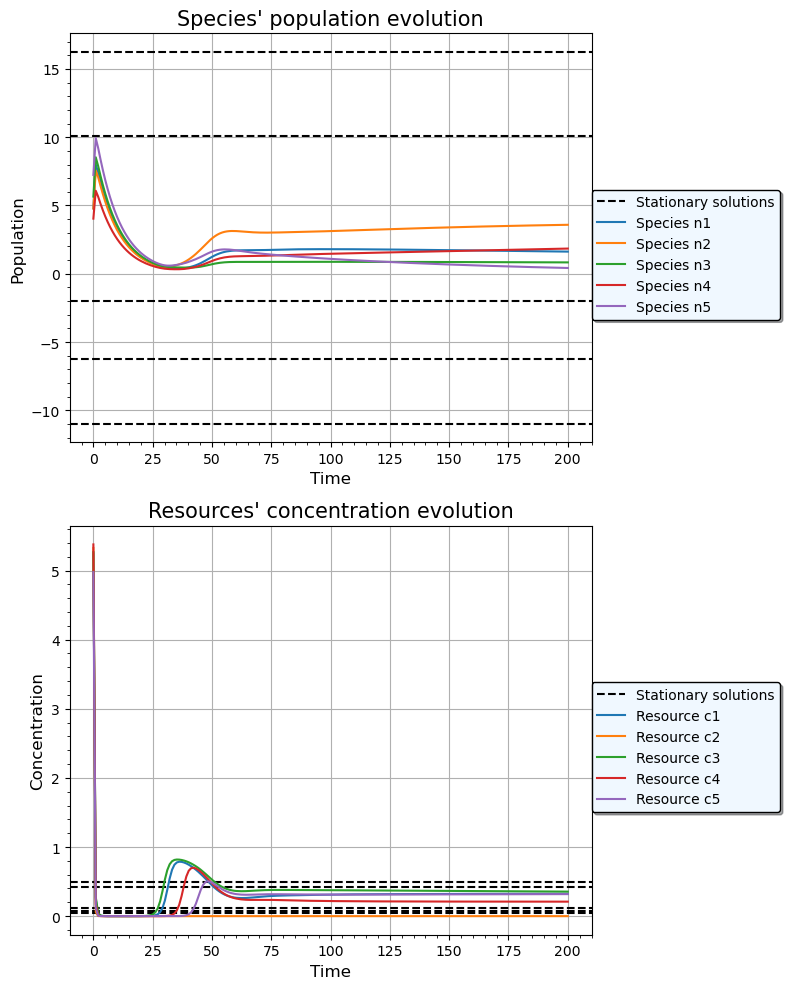

In [79]:
fig, ax_ = plt.subplots(2, 1, figsize=(8, 10))
ax, ax1 = ax_
for i in range(n_species):
    ax.axhline(y = n_star_[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax.plot(t, solution1[:, i], label = 'Species n' + str(i+1), zorder = 3)
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('Species\' population evolution', fontsize = 15)
    

ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for i in range(n_resources):
    ax1.axhline(y = c_star_[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax1.plot(t, solution1[:, n_species + i], label = 'Resource c' + str(i+1), zorder = 3)
    ax1.set_xlabel('Time', fontsize = 12)
    ax1.set_ylabel('Concentration', fontsize = 12)
    ax1.set_title('Resources\' concentration evolution', fontsize = 15)
    

ax1.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for a in ax_:
    a.minorticks_on()
    a.grid(zorder = 1)

fig.tight_layout()

## Approximation
Keeping the standard model with the values of the metabolic strategies' matrix $a_{ij}$ piked from a uniform distribution with values between $0$ and $0.2$ we notice that the analytical stationary solution in general does have negative values both for the concentration of the resources and for the population of the species. <br>
To solve this issues we make an approximation in order to make sure that the inverse of the metabolic strategies' matrix is semi-positive definite. <br>
What achieves that is making our matrix the product of a permutation matrix and a matrix with positive entries. <br>
In this case infact if we suppose that $A = DP$ where $D$ is a diagon matrix with all positive diagonal entries and $P$ is a permutation matrix, then $A^{-1} = P^{-1}D^{-1} = P^{T}D^{-1}$ with both therms being positive. <br>


In our case this corresponds to the fact that each species consumes only one resource and no two species are consume the same resource.




In [80]:
np.random.seed(8)
identity = np.eye(n_species, n_resources)
np.random.shuffle(identity)
metabolic_strategies = identity * np.random.uniform(0, 0.2,\
     size = (n_species, n_resources))

death_rate = 1/100

death_rate_vec = np.ones(n_species) * death_rate

In [81]:
print('Metabolic startegies:\n')
display(metabolic_strategies)
print('Death rate:\n')
display(death_rate_vec)

Metabolic startegies:



array([[0.        , 0.        , 0.        , 0.        , 0.08609376],
       [0.        , 0.        , 0.09567836, 0.        , 0.        ],
       [0.        , 0.14247491, 0.        , 0.        , 0.        ],
       [0.19477105, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.04495399, 0.        ]])

Death rate:



array([0.01, 0.01, 0.01, 0.01, 0.01])

In [82]:
metabolic_inv = np.linalg.inv(metabolic_strategies)
c_star = metabolic_inv.dot(death_rate_vec)
c_star

array([0.05134233, 0.07018779, 0.10451684, 0.22244968, 0.11615243])

In [83]:
mu_star = np.ones(n_species) - c_star

n_star = mu_star.dot(metabolic_inv)
n_star

array([10.26610443,  9.35930722,  6.52614677,  4.87062978, 17.29658174])

In [84]:

solution = odeint(system, y0, t, args=(n_resources, n_species,\
    metabolic_strategies, death_rate, 1), full_output=0)

# Saving solution
#pd.DataFrame(solution[0], columns = ['n1', 'n2', 'c1', 'c2', 'c3']).to_csv('../../data/week_5/CRM32.csv')

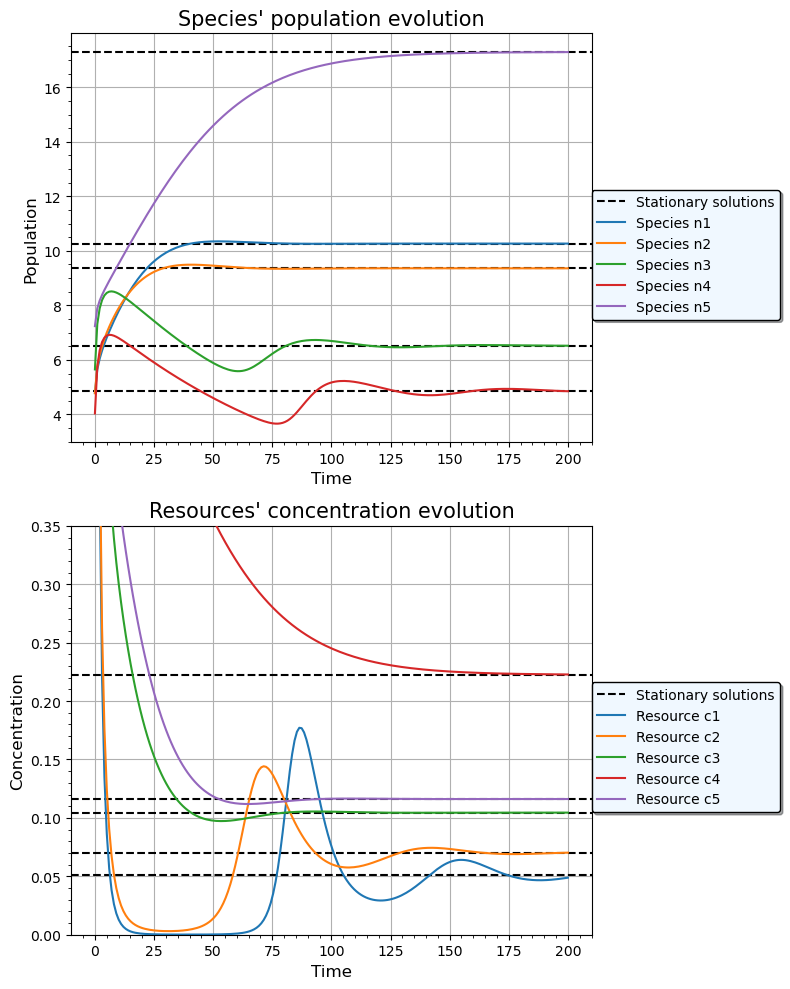

In [85]:
fig, ax_ = plt.subplots(2, 1, figsize=(8, 10))
ax, ax1 = ax_
for i in range(n_species):
    ax.axhline(y = n_star[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax.plot(t, solution[:, i], label = 'Species n' + str(i+1), zorder = 3)
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('Species\' population evolution', fontsize = 15)
    

ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for i in range(n_resources):
    ax1.axhline(y = c_star[i], color = 'black', linestyle = '--', label = 'Stationary solutions' if i == 0 else None,\
        zorder = 2)
    ax1.plot(t, solution[:, n_species + i], label = 'Resource c' + str(i+1), zorder = 3)
    ax1.set_xlabel('Time', fontsize = 12)
    ax1.set_ylabel('Concentration', fontsize = 12)
    ax1.set_title('Resources\' concentration evolution', fontsize = 15)
    ax1.set_ylim(0, 0.35)

ax1.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

for a in ax_:
    a.minorticks_on()
    a.grid(zorder = 1)

fig.tight_layout()

## Quasi-stationary approximation

In this $2^{nd}$ section we consider the **Quasi-static approximation**, that is, when the population changes the resource will quickly reach a new equilibrium before the resource can change again. <br>
This can be modeled by taking the approximation $\dot{c_i} = 0$ that will lead to the same solution as above: $c_i = c^*_i$.

<br/>

As far as the population dynamics is concerned, we keep the full equation,

$$

\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} \alpha_{\sigma i} c^*_i  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m

$$

In this section $\omega$ will be always contant and equal for all resources bu this time we'll set $\omega = 10 \cdot \vec{1}_i$.

As far as the resources's concentration,

$$
0 \quad = \quad \omega \cdot \cancel{c^*_i} \cdot (1 - c^*_i) -  \sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} \cancel{c^*_i};
$$

$$
c^*_i = 1 - \dfrac{1}{\omega}\sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i}
$$

Substituting back in the population dynamics we have,

$$
\dot{n}_{\sigma} \quad = \quad n_{\sigma} \cdot \left ( \sum\limits_{i = 1}^{p} \alpha_{\sigma i} \left [ 1 - \dfrac{1}{\omega}\sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} \right ]  - \delta_{\sigma} \right ); \quad \quad \quad \sigma = 1, \dots, m
$$

In [86]:
1 - 10 * np.array(np.random.uniform(0, 0.1, size = 5)).dot(metabolic_strategies)

array([0.99440383, 0.85969791, 0.9669468 , 0.98419037, 0.9228475 ])

In [87]:
t = np.linspace(0, 300, 300)
def system_qsa(y, t, n_resources, a, death_rate, omega):
    return_list = []
    n_vec = np.array(y)
    omega_vec = omega * np.ones(n_resources)
    for i in range(n_species):
        n = y[i]
        dn_dt = n * ( np.sum(a[i, :] * (1 - (1 / omega_vec[i]) * n_vec.dot(a)) ) - death_rate)
        return_list.append(dn_dt)
    
    return return_list

solution_qsa = odeint(system_qsa, initial_n, t, args=(n_resources, metabolic_strategies, death_rate, 10), full_output=0)

In [88]:
resources_qsa = 1 - 1/10 * np.array(solution_qsa[::np.newaxis]).dot(metabolic_strategies)

In [89]:
solution_full = odeint(system, y0, t, args=(n_species, n_resources, metabolic_strategies, death_rate, 10), full_output=0)

In [90]:
colors = ['khaki', 'mediumorchid', 'navy', 'firebrick', 'forestgreen']

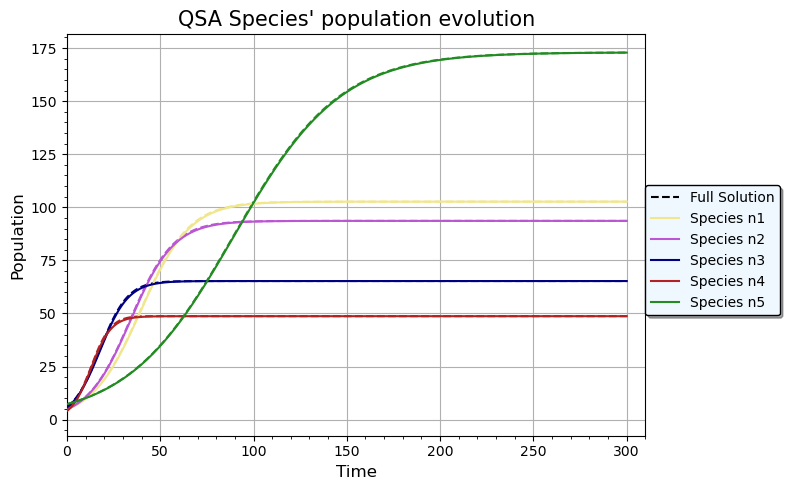

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(400, 1, color = 'black', linestyle = '--', label = 'Full Solution' if i == 0 else None)
    ax.plot(t, solution_qsa[:, i], label = 'Species n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t, solution_full[:, i], zorder = 2, linestyle = '--', color = colors[i])
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('QSA Species\' population evolution', fontsize = 15)
    
    
    
ax.set_xlim(0, 310)
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')
#ax.set_ylim(0, 20)

ax.minorticks_on()
ax.grid(zorder = 1)

fig.tight_layout()

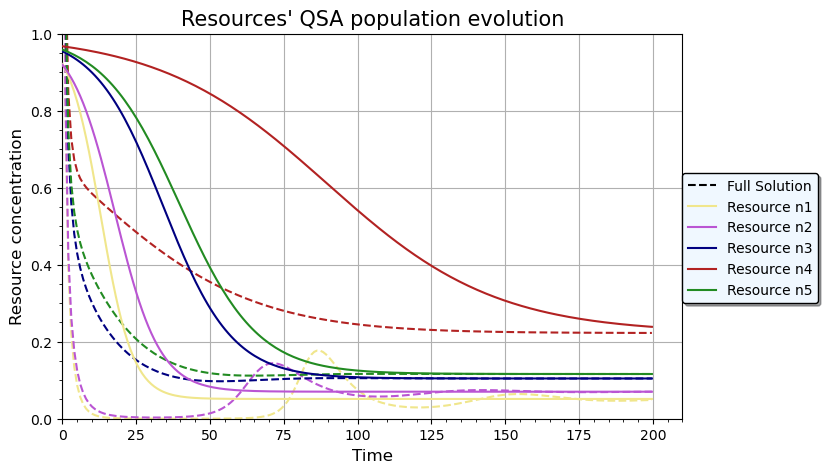

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(400, 1, color = 'black', linestyle = '--', label = 'Full Solution' if i == 0 else None)
    ax.plot(t[:200], resources_qsa[:, i][:200], label = 'Resource n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t[:200], solution[:, n_species + i], zorder = 2, linestyle = '--', color = colors[i])
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Resource concentration', fontsize = 12)
    ax.set_title('Resources\' QSA population evolution', fontsize = 15)


    
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')
ax.set_ylim(0, 1)
ax.set_xlim(0, 210)
ax.minorticks_on()
ax.grid(zorder = 1)
plt.show()

### Comments 

We can see form the above comparisons that in this setting and with our choice of paramters the **QSA** is a good approximation as the full solution for the species basically coincide with the **QSA**. <br>
We see in the evolution of the resources' concentration thet, in the **QSA**, after a brief transient from the initial condition, the concentrations reach the same stationary state as the full solution.

## Full solution and **QSA** comparison

In the follwing section we draw our matrix randomly $100$ times and we plot the Box-Whisker plot of the 
species' population at the end of our simulation ($t = 300$) of the full **CRM** and of the **QSA**, the latter  correspondto the **GLV** model. <br>

In [93]:
metabolics = [identity[np.random.choice(n_resources, size = n_species, replace = False),:] * np.random.uniform(0, 0.2,\
     size = (n_species, n_resources)) for _ in range(1000)]
statistics_qsa = [np.array(odeint(system_qsa, initial_n, t, args=(n_resources, metabolic, death_rate, 10),\
     full_output=0))[-1,:] for metabolic in metabolics]

In [94]:
statistics_species = reduce(lambda x, y: np.vstack([x, y]), statistics_qsa) 

In [95]:
statistics_full = [np.array(odeint(system, y0, t, args=(n_species, n_resources, metabolic, death_rate, 10),\
     full_output=0))[-1,:5] for metabolic in metabolics]

In [96]:
statistics_species_full = reduce(lambda x, y: np.vstack([x, y]), statistics_full) 

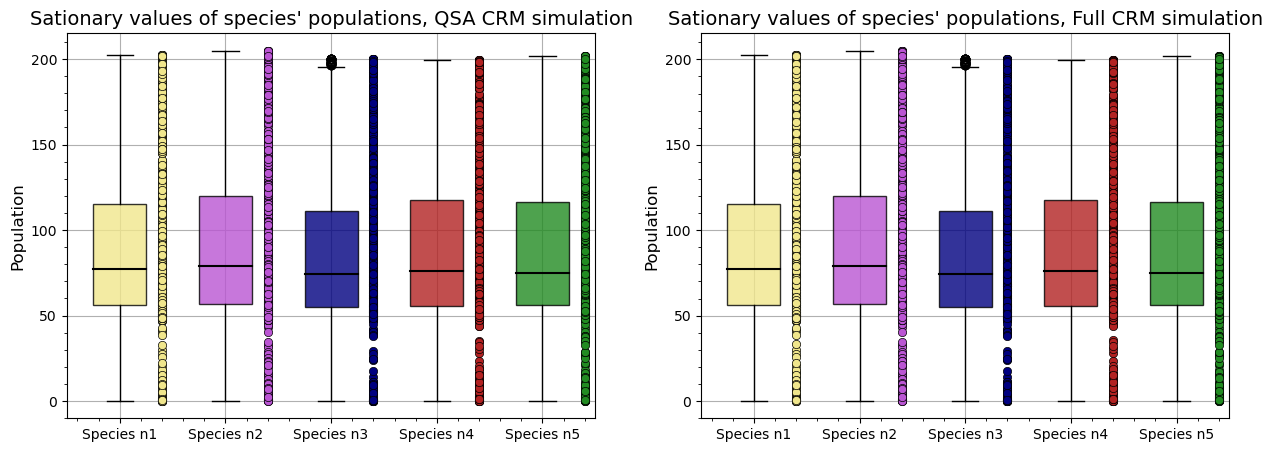

In [21]:
fig, ax_ = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = ax_
bp = ax1.boxplot(statistics_species, labels = ['Species n' + str(i+1) for i in range(n_species)], patch_artist=True,\
    medianprops = dict(color="black",linewidth=1.5), showfliers = True)

for i, patch in enumerate(bp['boxes']):
        patch.set(facecolor=colors[i], alpha=0.8, zorder=2)
        ax1.scatter(x = (i + 1.4) * np.ones(statistics_species.shape[0]), y = statistics_species[:, i], color = colors[i], zorder=3,\
            edgecolor = 'black', linewidths=0.5)

bp = ax2.boxplot(statistics_species_full, labels = ['Species n' + str(i+1) for i in range(n_species)], patch_artist=True,\
    medianprops = dict(color="black",linewidth=1.5), showfliers = True)

for i, patch in enumerate(bp['boxes']):
        patch.set(facecolor=colors[i], alpha=0.8, zorder=2)
        ax2.scatter(x = (i + 1.4) * np.ones(statistics_species_full.shape[0]), y = statistics_species_full[:, i], color = colors[i], zorder=3,\
            edgecolor = 'black', linewidths=0.5)

ax1.set_title('Sationary values of species\' populations, QSA CRM simulation', fontsize = 14)
ax2.set_title('Sationary values of species\' populations, Full CRM simulation', fontsize = 14)

for ax in ax_:
    ax.minorticks_on()
    ax.set_ylabel('Population', fontsize = 12)
    ax.grid(zorder = 1)
plt.show()

## Comparison of the full solution and the **QSA** for $\omega = \dfrac{1}{10}$

What we do now is to repeat the comparison between the full solution and the **QSA** approximation changing $\omega$ from $\omega = 10$ to $\omega = \dfrac{1}{10}$.<br>

We expect that the two setting do not coincide as in the previous setting but that the approximation worsens. We recall infact that the **QSA** assumes that that the resources' concentration change very fast with respect to the species. This way when the population changes the resources will quickly reach a new equilibrium before the population can change again and so effectively the species will see stationary resources. 

<br/>

Lowering $\omega$ will solw down the resources causing the approximation to worsen. Let's see with a simple empirical argument why the lowering of $\omega$ causes a slowing down in the resources' dynamics. 

<br/>

The **ODE** for $c$ yells,

$$
\dot{c}_i \quad = \quad \omega \cdot c_i(1 - c_i) -  \sum\limits_{\sigma = 1}^{m} n_{\sigma} \alpha_{\sigma i} r_i(c_i); \quad \quad \quad i = 1, \dots, p
$$

Neglecting for the moment the second term and writing the equation with finite differnces we have,

$$
\Delta{c_i} \quad = \quad \omega \cdot c_i(1 - c_i) \cdot \Delta{t};
$$

So in the 2 cases we deal with we have $\Delta{c_i} \propto 10 \Delta{t} \quad$ and $\quad \Delta{c_i} \propto  \dfrac{1}{10} \Delta{t} \quad$ respectively. <br>
So, why in the former case if we wanna a change in $c_i$ of $10$ we need $\Delta{t} = 1$, in the latter we need $\Delta{t} = 100$ and thus to obtain the same change in $c_i$ we now need more time.

<br/>

We see from the simulation that, while in the previous setting the two solutions coincide, now the two simulations reach similar values much later in time. Note also how before we were simulating for $t = 300$ steps while now we are doing it for $t = 1000$ steps.


### Caveat to take care of

Remaining with the same initial values for the initial population as in the above sections we would have occurred in negative starting values for the concentrations, something that does not make physical sense. 
<br/>
Calling $\bar{c^*_i}$ and $\bar{n_{\sigma}}$ teh initial values for the concentrations and the population respectively, we have to satisfy,
$$
\bar{c^*_i} = 1 - \dfrac{1}{\omega}\sum\limits_{\sigma = 1}^{m} \bar{n}_{\sigma} \alpha_{\sigma i} \geq 0;
$$

With $\omega = \dfrac{1}{10}$ we have,

$$
\sum\limits_{\sigma = 1}^{m} \bar{n}_{\sigma} \alpha_{\sigma i} \leq \dfrac{1}{10}
$$

Having $a_{\sigma i}$ all values $\leq 1$  (in reality only $1$ value of each column will be $\neq 0$) drawing $\bar{n}_{\sigma}$ from a uniform $\mathcal{U} \left [ 0, 0.1 \right ]$ will suffice.

In [26]:
t = np.linspace(0, 1000, 1000)
new_initial_n = np.random.uniform(0, 0.1, size = 5)
solution_qsa_2 = odeint(system_qsa, new_initial_n, t, args=(n_resources, metabolic_strategies, death_rate, 0.1), full_output=0)
solution_full_2 = odeint(system, list(new_initial_n) + initial_c, t, args=(n_species, n_resources, metabolic_strategies, death_rate, 0.1), full_output=0)

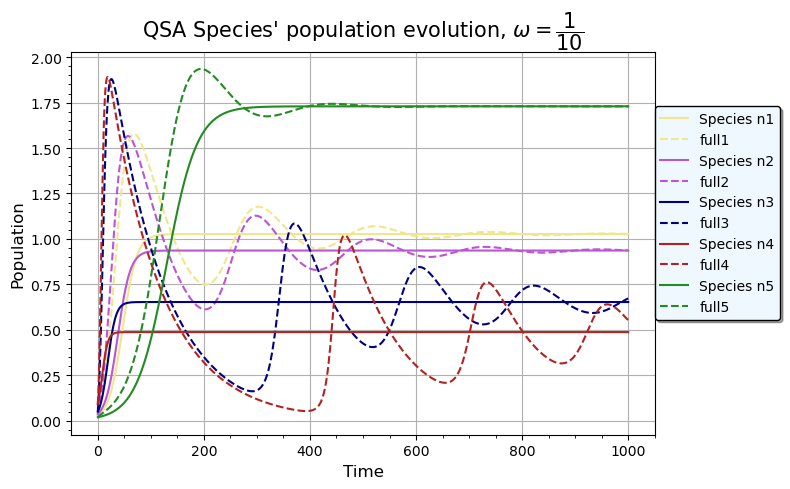

In [27]:
t = np.linspace(0, 1000, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(t, solution_qsa_2[:, i], label = 'Species n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t, solution_full_2[:, i], label = 'full' + str(i+1), zorder = 3, color = colors[i], linestyle = '--')
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Population', fontsize = 12)
    ax.set_title('QSA Species\' population evolution, $\omega = \dfrac{1}{10}$', fontsize = 15)
    
    
    
#ax.set_xlim(0, 310)
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')
#ax.set_ylim(0, 20)

ax.minorticks_on()
ax.grid(zorder = 1)

fig.tight_layout()

In [24]:
resources_qsa_2 = 1 - 10 * np.array(solution_qsa_2[::np.newaxis]).dot(metabolic_strategies)


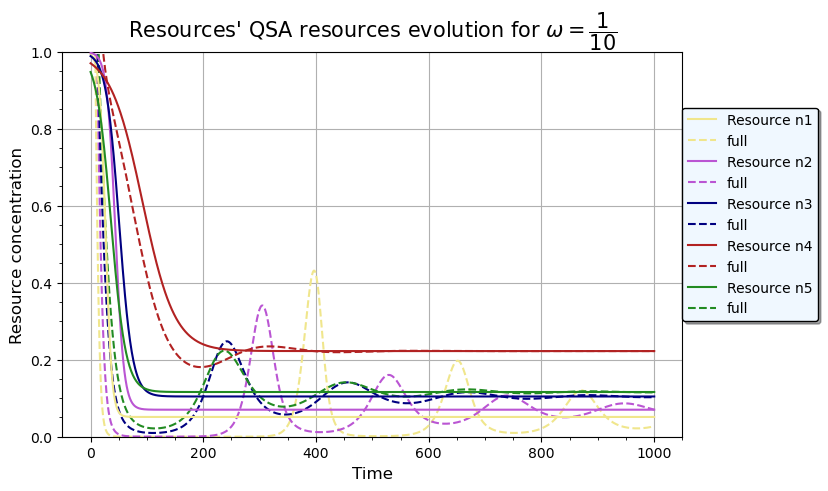

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_species):
    ax.plot(t, resources_qsa_2[:, i], label = 'Resource n' + str(i+1), zorder = 3, color = colors[i])
    ax.plot(t, solution_full_2[:, n_species + i], zorder = 2, linestyle = '--', color = colors[i], label = 'full')
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Resource concentration', fontsize = 12)
    ax.set_title('Resources\' QSA resources evolution for $\omega = \dfrac{1}{10}$', fontsize = 15)


    
ax.legend(facecolor = 'aliceblue', loc = (1, 0.3), shadow = True, edgecolor = 'black')

ax.set_ylim(0, 1)
ax.minorticks_on()
ax.grid(zorder = 1)
plt.show()